In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as td
import os

import numpy as np
import skimage


from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import copy
import pdb

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# dataloader and processing

In [3]:
class styleTransferDataset(td.Dataset):
    def __init__(self, root_dir, mode='train', image_size=(512,512)):
        super(styleTransferDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)
    
    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "StyleDataset(mode={}, image_size={}, sigma={})".format(self.mode, self.image_size)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        img = Image.open(img_path).convert('RGB')
        np_img = np.array(img, dtype=np.float32)
        np_img = np.transpose(np_img, axes=(2,0,1))
        np_img = skimage.transform.resize(np_img, (3, self.image_size[0], self.image_size[1]), anti_aliasing=True)
        np_img /= 255
        tensor_img = torch.from_numpy(np_img).to(device, torch.float32)
        return tensor_img

In [4]:
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [41]:
dataset_root_dir = './dataset'
style_set = styleTransferDataset(dataset_root_dir, mode='style')
content_set = styleTransferDataset(dataset_root_dir, mode='content')

Text(0.5, 1.0, 'content')

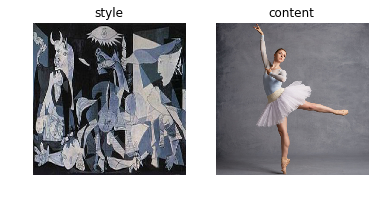

In [42]:
fig, axes = plt.subplots(ncols=2)
myimshow(style_set[0], axes[0])
axes[0].set_title('style')
myimshow(content_set[0], axes[1])
axes[1].set_title('content')

In [43]:
len(style_set)

2

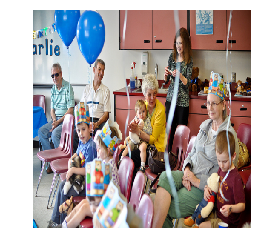

# loss and normalization

In [45]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [46]:
def gram_matrix(input):
    n, c, h, w = input.shape

    features = input.view(n * c, h * w) 

    G = torch.mm(features, features.t())

    return G.div(n * c * h * w)


In [47]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [48]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


# model

In [49]:
def get_style_model_and_losses(net, style_img, content_img, style_layers, content_layers):

    net = copy.deepcopy(net)
    

    content_losses = []
    style_losses = []
    
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)

    content_losses = []
    style_losses = []

    i = 0
    for layer in net.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(label, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i+1)]

    return model, style_losses, content_losses


In [50]:
def style_transfer(input_img, tensor_style, tensor_content, total_steps=300, style_weight=1000000, content_weight=1):

    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


    net = models.vgg19(pretrained=True).features.to(device).eval()

    model, style_losses, content_losses = get_style_model_and_losses(net, tensor_style, tensor_content, style_layers=style_layers, content_layers=content_layers)

    optimizer = optim.LBFGS([input_img.requires_grad_()])

    step = [0]
    while step[0] <= total_steps:
        
        def closure():
            input_img.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            
            total_style_loss = 0
            total_content_loss = 0
        
            #img_show(tensor_content, input_img, tensor_style)
          
            model(input_img)

            for sl in style_losses:
                total_style_loss += sl.loss
                #print('style_loss', sl.loss)
            for cl in content_losses:
                total_content_loss += cl.loss
                #print('content_loss', cl.loss)
            
            total_style_loss *= style_weight
            total_content_loss *= content_weight

            loss = total_style_loss + total_content_loss
            loss.backward()
            
            step[0] += 1
            if step[0] % 10 == 0:
                print('Step [{}], style_loss {:4f}, content_loss {:4f}'.format(step[0], total_style_loss.item(), total_content_loss.item()))
            
            return total_style_loss + total_content_loss

        optimizer.step(closure)


    input_img.data.clamp_(0, 1)
    return input_img

In [ ]:
style_idx = 1
content_idx = 1
tensor_style = torch.unsqueeze(style_set[style_idx],0)
tensor_content = torch.unsqueeze(content_set[content_idx],0)
input_img = tensor_content.clone()


output = style_transfer(input_img, tensor_style, tensor_content)
fig, axes = plt.subplots(ncols=3, figsize=(10,8))
myimshow(tensor_style[0], axes[0])
axes[0].set_title('style')
myimshow(tensor_content[0], axes[1])
axes[1].set_title('content')
myimshow(output[0], axes[2])
axes[2].set_title('output')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Step [10], style_loss 910.679321, content_loss 11.782455
Step [20], style_loss 432.946320, content_loss 14.087386
Step [30], style_loss 287.858826, content_loss 15.717125
Step [40], style_loss 219.838425, content_loss 16.202770
Step [50], style_loss 177.336777, content_loss 16.659262
Step [60], style_loss 139.999176, content_loss 17.067430
Step [70], style_loss 108.123024, content_loss 17.717594
Step [80], style_loss 86.952736, content_loss 18.203926
Step [90], style_loss 67.471359, content_loss 18.804455
Step [100], style_loss 52.892475, content_loss 19.119734
Step [110], style_loss 45.751934, content_loss 19.104898
Step [120], style_loss 39.217045, content_loss 19.112562
Step [130], style_loss 34.668232, content_loss 18.965956
Step [140], style_loss 31.260195, content_loss 18.647385
Step [150], style_loss 27.253582, content_loss 18.409533
Step [160], style_loss 24.220943, content_loss 18.023539
Step [170], style_loss 21.353804, content_loss 17.567415
Step [180], style_loss 19.196228,